In [2]:
import os
from transformers import AutoTokenizer, BertModel, AutoModel, pipeline, BertForSequenceClassification, BertTokenizerFast
import torch
from torch.utils.data import Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
from huggingface_hub import PyTorchModelHubMixin, notebook_login
import numpy as np
import pandas as pd
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import plotly.express as px

### Pre-Processing

In [3]:
# movies_df = pd.read_csv('./Movies.csv')
movies_df = pd.read_csv('Movies.csv')


movies_df = movies_df[["Plot", "Genre"]]
drop_indices = movies_df[movies_df["Genre"] == "unknown" ].index
movies_df.drop(drop_indices, inplace=True)

movies_df["Genre"].replace({"sci-fi": "science fiction", "romantic comedy": "romance"}, inplace=True)
shortlisted_genres = movies_df["Genre"].value_counts().reset_index(name="count").query("count > 200")["Genre"].tolist()
movies_df = movies_df[movies_df["Genre"].isin(shortlisted_genres)].reset_index(drop=True)
movies_df = movies_df.sample(frac=1).reset_index(drop=True)
movies_df = movies_df.groupby("Genre").head(400).reset_index(drop=True)
movies_df = movies_df[["Plot", "Genre"]]

C:\Users\matin\AppData\Local\Temp\ipykernel_25860\1265181715.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_df["Genre"].replace({"sci-fi": "science fiction", "romantic comedy": "romance"}, inplace=True)


In [4]:
labels = movies_df["Genre"].unique().tolist()
labels = [s.strip() for s in labels]
labels, len(labels)

(['comedy',
  'drama',
  'romance',
  'comedy, drama',
  'adventure',
  'thriller',
  'western',
  'film noir',
  'action',
  'horror',
  'crime drama',
  'Drama',
  'science fiction',
  'mystery',
  'animation',
  'crime',
  'war',
  'musical',
  'Comedy',
  'family',
  'fantasy'],
 21)

In [5]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}
label2id={label:id for id,label in enumerate(labels)}

In [6]:
movies_df["labels"]=movies_df.Genre.map(lambda x: label2id[x.strip()])

<Axes: ylabel='count'>

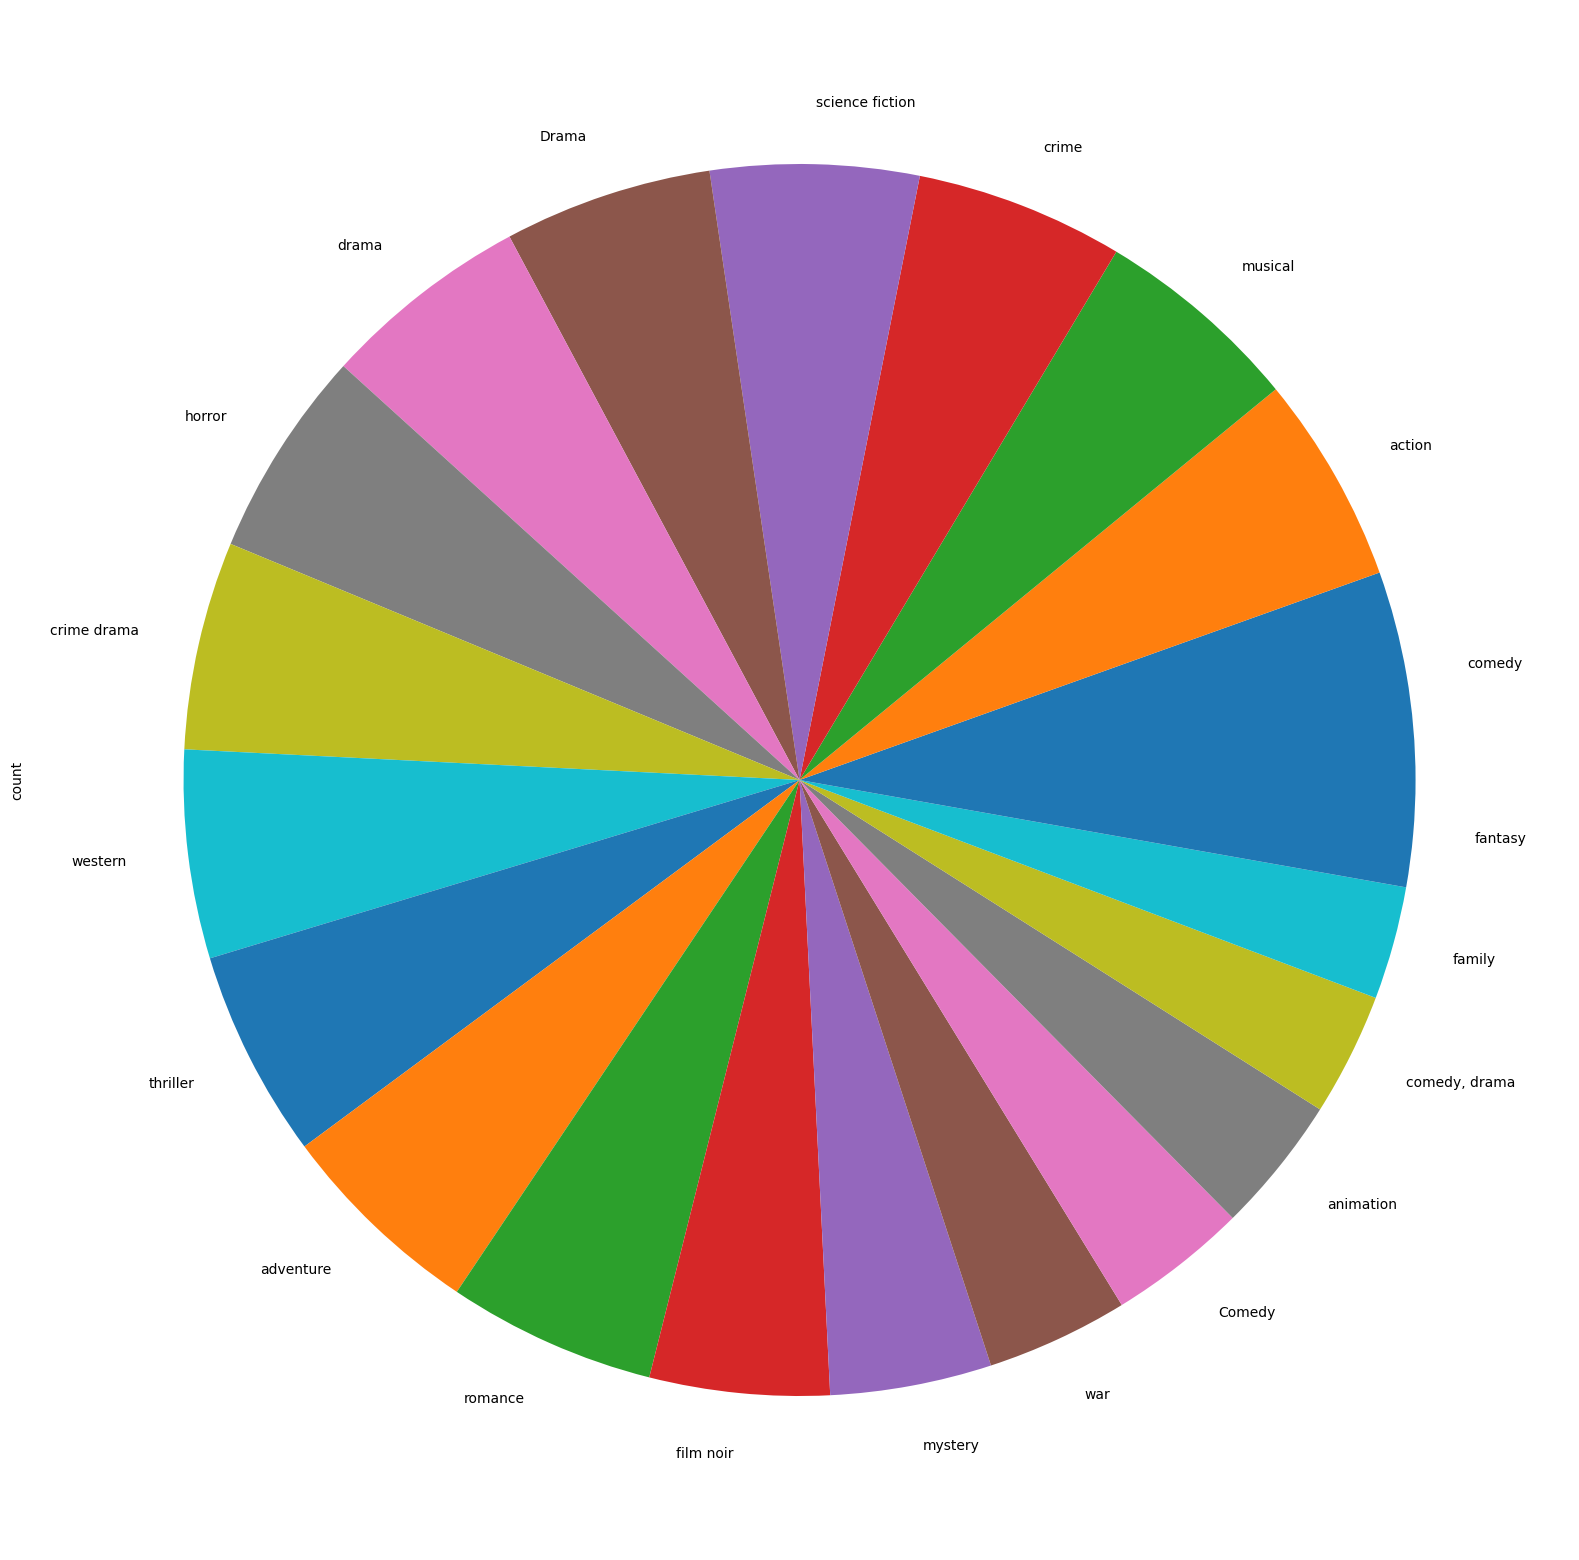

In [7]:
movies_df.Genre.value_counts().plot(kind='pie', figsize=(20,20))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# split data

In [9]:
mask = np.random.rand(len(movies_df)) < 0.8
train_df = movies_df[mask].reset_index(drop=True)
test_df = movies_df[~mask].reset_index(drop=True)
print(len(train_df), len(test_df))

5910 1406


# define datasets

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        return [{key: val.squeeze(0).to(device) for key, val in self.tokenizer(self.df.loc[i, "Plot"], return_tensors="pt",
                padding="max_length", max_length=self.max_len, truncation=True).items()},
                torch.tensor(self.df.loc[i, "labels"]).to(device, dtype=torch.long)
                ]

# train model

In [12]:
from sentence_transformers import SentenceTransformer, InputExample, losses

In [13]:
model = SentenceTransformer('thenlper/gte-base')

In [14]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [11]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-cased", max_length=512)
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [13]:
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

for i in range(0, 10):
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = False

for i in range(10, 12):
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = True

for param in model.bert.pooler.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

In [14]:
train_dataset = CustomDataset(train_df, tokenizer, 512)
test_dataset = CustomDataset(train_df, tokenizer, 512)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [15]:
epochs = 20
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
train_accuracy_history = []
train_loss_history = []
for i in range(1, epochs+1):
    print(f"------------------------------------ epoch {i} ------------------------------------")
    train_data_correct = 0
    train_data_total = 0
    train_per_epoch_loss = 0


    batches = tqdm(train_dataloader, unit="batch")
    for texts, labels in batches:

        optimizer.zero_grad()
        out = model(**texts, labels=labels)
        loss, predictions = out["loss"], torch.nn.functional.softmax(out["logits"], dim=1)
        # predictions = torch.nn.functional.softmax(model(**texts, labels=labels).logits, dim=1)
        # loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()


        train_data_correct += torch.sum(torch.argmax(predictions, dim=1) == labels).item()
        train_data_total += len(predictions)
        train_per_epoch_loss += loss.item()

        batches.set_postfix({"loss":loss.item(),
                            "accuracy":train_data_correct/train_data_total})


    train_accuracy_history.append(train_data_correct / train_data_total)
    train_loss_history.append(train_per_epoch_loss / len(train_dataloader))




    print(f"train_acc: {train_accuracy_history[-1]:.3f} train loss: {train_loss_history[-1]:.3f}")


------------------------------------ epoch 1 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

train_acc: 0.331 train loss: 2.113
------------------------------------ epoch 2 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

train_acc: 0.465 train loss: 1.625
------------------------------------ epoch 3 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

train_acc: 0.526 train loss: 1.435
------------------------------------ epoch 4 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

train_acc: 0.587 train loss: 1.218
------------------------------------ epoch 5 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

train_acc: 0.639 train loss: 1.066
------------------------------------ epoch 6 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

train_acc: 0.691 train loss: 0.923
------------------------------------ epoch 7 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

train_acc: 0.729 train loss: 0.797
------------------------------------ epoch 8 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

train_acc: 0.773 train loss: 0.671
------------------------------------ epoch 9 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

train_acc: 0.802 train loss: 0.564
------------------------------------ epoch 10 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

train_acc: 0.835 train loss: 0.486
------------------------------------ epoch 11 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

train_acc: 0.839 train loss: 0.483
------------------------------------ epoch 12 ------------------------------------


  0%|          | 0/369 [00:00<?, ?batch/s]

In [ ]:
# torch.save(model, "bert.pth")